In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
from sklearn import metrics
from bayes_opt import BayesianOptimization
import shap
import import_ipynb
import final_split_train_test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle

C:\Users\uc212037\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


importing Jupyter notebook from final_split_train_test.ipynb


In [3]:
whole_data_original = pd.read_csv("train.csv")

In [4]:
whole_data = shuffle(whole_data_original)

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(whole_data, whole_data['target'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    train, test = whole_data.iloc[train_index], whole_data.iloc[test_index]
    print(train.shape)    

TRAIN: [156309  57663  83950 ...  99220 169289  72481] TEST: [165473  30776  44681 ...  24421  41871   9548]
(100000, 202)


In [6]:
x_train = train.iloc[:,2:]
y_train = train['target']
x_test = test.iloc[:,2:]
y_test = test['target']
features = [column for column in train.columns if column not in ['ID_code', 'target']]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("features", len(features))

x_train shape:  (100000, 200)
y_train shape:  (100000,)
x_test shape:  (100000, 200)
features 200


In [7]:
# Makding sure the target classes are equally splitted into two set. 
# Each set contains the same amount of target 0  and target 1 classes.
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)
print("-----------------------------")
print(y_test[y_test==0].shape)
print(y_test[y_test==1].shape)

(89951,)
(10049,)
-----------------------------
(89951,)
(10049,)


# Set up the parameter with default values for benchmark model: 

In [11]:
# Set the parameter with default values for benchmark model
params = {
    # Core Parameters
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'tree_learner': 'serial',
    'num_threads': 0,
    'seed': 42,
    
    # Learning Control Parameters
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,  
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'feature_fraction': 1.0,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'bagging_seed': 42,
    
    # Others
    'verbosity ': 1,
    'boost_from_average': True,
    'metric': 'auc',
}

# Train the model with 5-fold cross validation:

In [12]:
import time
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

num_folds = 5

folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=44000)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx][features], label=y_train.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    clf.save_model('{:03d}.txt'.format(fold_))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits



Fold 0
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.960336	valid_1's auc: 0.869258
[2000]	training's auc: 0.986665	valid_1's auc: 0.884802
[3000]	training's auc: 0.996148	valid_1's auc: 0.888566
[4000]	training's auc: 0.998917	valid_1's auc: 0.889271
[5000]	training's auc: 0.999715	valid_1's auc: 0.889348
[6000]	training's auc: 0.999937	valid_1's auc: 0.889144
[7000]	training's auc: 0.999988	valid_1's auc: 0.888832
[8000]	training's auc: 1	valid_1's auc: 0.888541
Early stopping, best iteration is:
[4879]	training's auc: 0.999663	valid_1's auc: 0.889385
Fold 1
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.96181	valid_1's auc: 0.875515
[2000]	training's auc: 0.986819	valid_1's auc: 0.887781
[3000]	training's auc: 0.996088	valid_1's auc: 0.890825
[4000]	training's auc: 0.999013	valid_1's auc: 0.891098
[5000]	training's auc: 0.999773	valid_1's auc: 0.89066
[6000]	training's auc: 0.999958	valid_1's auc: 0

In [13]:
from sklearn.metrics import roc_auc_score
print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))

CV score: 0.88843 


In [14]:
print("CV score: {:<8.5f}".format(roc_auc_score(y_test, predictions)))

CV score: 0.89388 


In [15]:
np.savetxt('benchmark_result.txt', predictions)

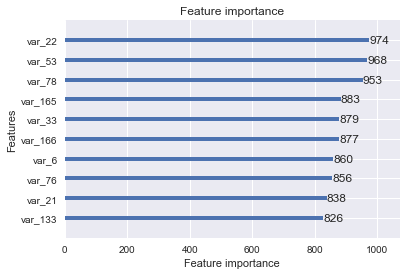

In [113]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/uc212037/Downloads/graphviz-2.38/release/bin'

## plot importance 
ax = lgb.plot_importance(clf, max_num_features=10)
plt.show()

In [114]:
# Create tree
graph = lgb.create_tree_digraph(clf, tree_index=2, show_info=['split_gain'])
graph.render(view=True)

'Digraph.gv.pdf'

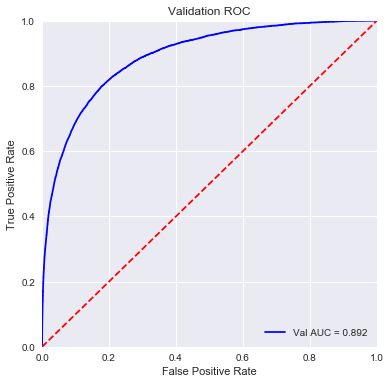

In [115]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

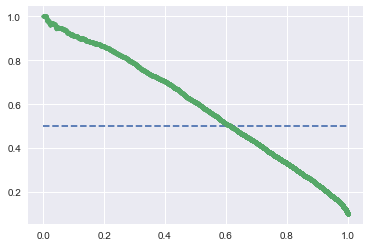

auc:  0.5927732991987414
ap 0.5927969085517574


In [103]:
# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

auc = auc(recall, precision)
ap = average_precision_score(y_test, predictions)

# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

print('auc: ', auc)
print('ap', ap)

Average precision-recall score RF: 0.5927969085517574


Text(0.5,1,'2-class Precision-Recall curve: AP=0.59')

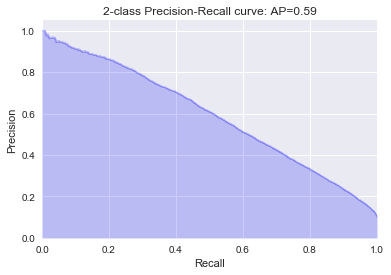

In [105]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score RF: {}'.format(average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [7]:
x_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
whole_data.to_csv('whole_data.csv', index=False)